<a href="https://colab.research.google.com/github/Lustiyana/ML_Capstone-Project/blob/main/Capstone_Project(Klasifikasi_Sampah).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0

Found 8539 files belonging to 9 classes.


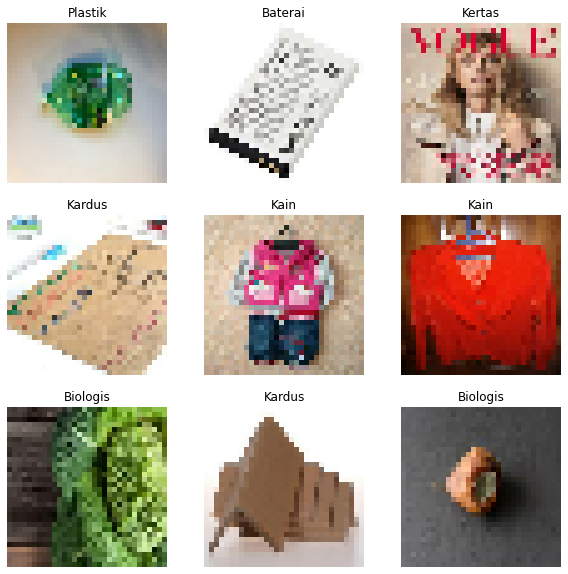

In [17]:
img_height, img_width = 32, 32
batch_size = 20

data = tf.keras.utils.image_dataset_from_directory("drive/MyDrive/Capstone-Project/dataset-jenis-sampah/",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
class_name = ['Baterai', 'Biologis', 'Kaca', 'Kain', 'Kardus', 'Kertas', 'Metal', 'Plastik', 'Sepatu']
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_name[labels[i]])
    plt.axis("off")

In [18]:
d = pd.DataFrame()
directory = "drive/MyDrive/Capstone-Project/dataset-jenis-sampah/"

for name in os.listdir(directory):
  temp = pd.DataFrame()
  temp['dir'] = np.nan
  temp['target'] = name
  i = 0
  for image in os.listdir(directory + name):
    temp.loc[i, 'dir'] = directory+name+ "/" + image
    temp.loc[i, 'name'] = name+ "/" + image
    temp.loc[i, 'target'] = name
    i += 1
  d = pd.concat([d, temp], ignore_index=True)
  del temp


data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)
train_data, val_data = train_test_split(d, test_size=0.1, random_state=42)
val_data, test_data = train_test_split(val_data, test_size=0.5, random_state=42)

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

len(train_data), len(val_data), len(test_data)

(7685, 427, 427)

In [19]:
train_generator = data_generator.flow_from_dataframe(
    dataframe=train_data,
    directory=directory,
    x_col='name',
    y_col='target',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64,
    seed=42)

Found 7685 validated image filenames belonging to 9 classes.


In [20]:
val_generator = data_generator.flow_from_dataframe(
    dataframe=val_data,
    directory=directory,
    x_col='name',
    y_col='target',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64,
    seed=42)

Found 427 validated image filenames belonging to 9 classes.


In [21]:
test_generator = data_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=directory,
    x_col='name',
    y_col='target',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=42)

Found 427 validated image filenames belonging to 9 classes.


In [22]:
base = EfficientNetB0(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224, 224, 3),
)
out = base.output
out = Flatten()(out)
out = Dense(100, activation='relu')(out)
result = Dense(len(class_name),
            activation = 'softmax',
            kernel_initializer = 'random_uniform'
            )(out)
model = Model(
    inputs = base.input,
    outputs = result
)

for layer in base.layers:
    layer.trainable=False

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics='accuracy'
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [23]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
callback = EarlyStopping(monitor='val_loss', patience=10,verbose=1)
train_samples = train_generator.samples // 64
validation_samples = val_generator.samples // 64
model.fit(
    train_generator,
    steps_per_epoch=train_samples,
    epochs=10,
    validation_data=val_generator,
    callbacks=callback,
    verbose = 1,
    validation_steps=validation_samples)

Epoch 1/10
120/120 [==============================] - 403s 3s/step - loss: 0.2885 - accuracy: 0.9137 - val_loss: 0.2567 - val_accuracy: 0.9245
Epoch 2/10
120/120 [==============================] - 426s 4s/step - loss: 0.0548 - accuracy: 0.9825 - val_loss: 0.2887 - val_accuracy: 0.9323
Epoch 3/10
120/120 [==============================] - 363s 3s/step - loss: 0.0358 - accuracy: 0.9888 - val_loss: 0.2741 - val_accuracy: 0.9427
Epoch 4/10
120/120 [==============================] - 361s 3s/step - loss: 0.0161 - accuracy: 0.9949 - val_loss: 0.2778 - val_accuracy: 0.9427
Epoch 5/10
120/120 [==============================] - 361s 3s/step - loss: 0.0120 - accuracy: 0.9965 - val_loss: 0.2018 - val_accuracy: 0.9557
Epoch 6/10
120/120 [==============================] - 362s 3s/step - loss: 0.0073 - accuracy: 0.9975 - val_loss: 0.3603 - val_accuracy: 0.9271
Epoch 7/10
120/120 [==============================] - 374s 3s/step - loss: 0.0194 - accuracy: 0.9949 - val_loss: 0.4686 - val_accuracy: 0.9062

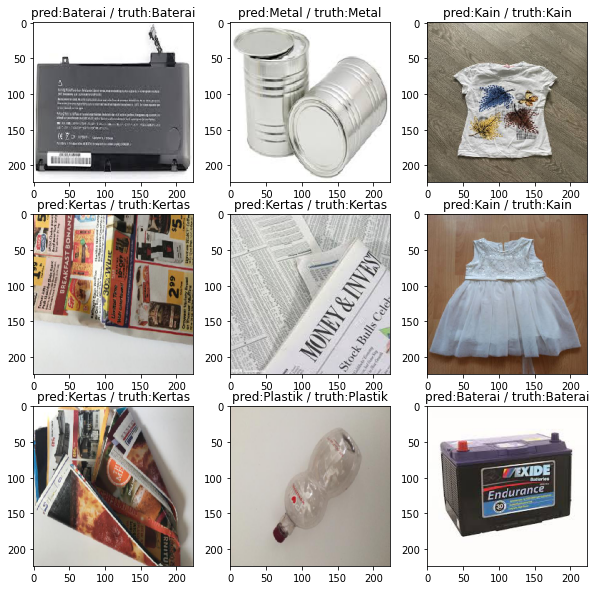

In [30]:
test_x, test_y = val_generator.__getitem__(1)

preds = model.predict(test_x)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_x[i].astype('uint8'))
    plt.title('pred:%s / truth:%s' % (class_name[np.argmax(preds[i])], class_name[np.argmax(test_y[i])]))